In [4]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('msmarco-bert-base-dot-v5')

In [5]:
from torch import Tensor
query_embedding = model.encode("keyboard")
passage_embedding = model.encode("flower")

similarity: Tensor = util.cos_sim(query_embedding, passage_embedding)
print("Similarity: ", similarity.item())


Similarity:  0.9229611158370972


In [6]:
import pandas as pd

men_dataset_path = "../../datasets/MEN/MEN_dataset_natural_form_full"

# Read the data into a pandas DataFrame
df = pd.read_csv(
    men_dataset_path, sep=" ", header=None, names=["word1", "word2", "score"]
)

df["score"] = df["score"] / 50
df = df.sample(frac=1, random_state=42)
df.head(10)

,word1,word2,score
1801,jean,washing,0.42
1190,blurred,lens,0.60
1817,lunch,morning,0.42
251,daffodils,plant,0.84
2505,animals,sandwich,0.22
1117,bathroom,floor,0.62
1411,birds,wild,0.54
2113,animals,clown,0.32
408,cafe,lunch,0.80
2579,friends,rusty,0.20


Using transformer it takes roughly 40 seconds to compute all similiry scores

In [7]:
def similarity(word1: str, word2: str, model: SentenceTransformer) -> float:
    w1_embedding = model.encode(word1)
    w2_embedding = model.encode(word2)
    return util.cos_sim(w1_embedding, w2_embedding).item()


df["similarity"] = df.apply(
    lambda row: similarity(row["word1"], row["word2"], model=model), axis=1
)

df.head(10)

,word1,word2,score,similarity
1801,jean,washing,0.42,0.909071
1190,blurred,lens,0.60,0.927490
1817,lunch,morning,0.42,0.927295
251,daffodils,plant,0.84,0.918377
2505,animals,sandwich,0.22,0.917721
1117,bathroom,floor,0.62,0.935253
1411,birds,wild,0.54,0.930866
2113,animals,clown,0.32,0.929584
408,cafe,lunch,0.80,0.938428
2579,friends,rusty,0.20,0.910760


There is no OOV. Words are tokenized into subwords, like in FastText embedding.

In [8]:
OOV_pairs = df[df['similarity'].isnull()]
OOV_pairs.head(10)

,word1,word2,score,similarity


Min value and max value are too high. This model is desined primarly for sentences, not for single words.

In [9]:
similarity = df['similarity']
min_value = similarity.min()
max_value = similarity.max()
display(f"Max: {max_value}",f"Min: {min_value}")

'Max: 0.9924193024635315'

'Min: 0.8468595147132874'

In [10]:
query_embedding = model.encode("There was a pretty sunny day.")
passage_embedding = model.encode("The house was dark and old.")

similarity: Tensor = util.cos_sim(query_embedding, passage_embedding)
print("Similarity: ", similarity.item())


Similarity:  0.8664148449897766


In [11]:
actual_class_threshold = 0.5
df["actual_class"] = df["score"] > actual_class_threshold
df.head(10)

,word1,word2,score,similarity,actual_class
1801,jean,washing,0.42,0.909071,False
1190,blurred,lens,0.60,0.927490,True
1817,lunch,morning,0.42,0.927295,False
251,daffodils,plant,0.84,0.918377,True
2505,animals,sandwich,0.22,0.917721,False
1117,bathroom,floor,0.62,0.935253,True
1411,birds,wild,0.54,0.930866,True
2113,animals,clown,0.32,0.929584,False
408,cafe,lunch,0.80,0.938428,True
2579,friends,rusty,0.20,0.910760,False


In [12]:
import numpy as np

y_true = np.where(df["actual_class"], 1, 0)
from sklearn.metrics import precision_recall_curve
y_similarity_scores = df['similarity'].to_numpy()

precision, recall, thresholds = precision_recall_curve(y_true, y_similarity_scores)

display(thresholds)

array([0.84685951, 0.85285538, 0.85300374, ..., 0.99199373, 0.99202937,
       0.9924193 ])

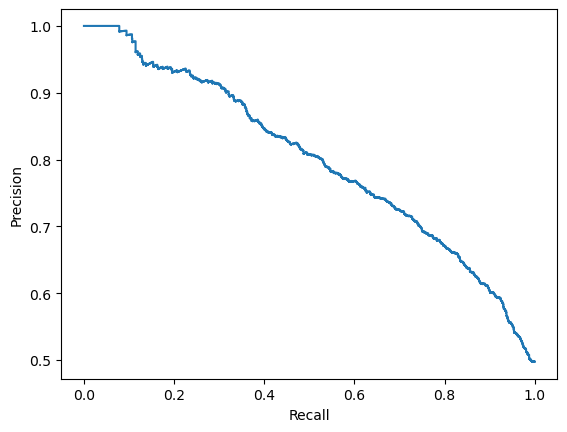

In [13]:
from sklearn.metrics import PrecisionRecallDisplay
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()

In [1]:
from sentence_transformers import SentenceTransformer, util
from torch import Tensor
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
import pandas as pd

def test_model(model_name: str | None = None, input_model=None):
    if input_model:
        model = input_model
    else:
        model = SentenceTransformer(model_name)

    def similarity(word1: str, word2: str, model: SentenceTransformer) -> float:
        w1_embedding = model.encode(word1)
        w2_embedding = model.encode(word2)
        return util.cos_sim(w1_embedding, w2_embedding).item()

    men_dataset_path = "../../datasets/MEN/MEN_dataset_natural_form_full"

    df = pd.read_csv(
        men_dataset_path, sep=" ", header=None, names=["word1", "word2", "score"]
    )

    df["score"] = df["score"] / 50
    df = df.sample(frac=1, random_state=42)

    actual_class_threshold = 0.5
    df["actual_class"] = df["score"] > actual_class_threshold

    y_true = np.where(df["actual_class"], 1, 0)

    df["similarity"] = df.apply(
        lambda row: similarity(row["word1"], row["word2"], model=model), axis=1
    )
    y_similarity_scores = df['similarity'].to_numpy()

    precision, recall, thresholds = precision_recall_curve(y_true, y_similarity_scores)
    pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
    pr_display.plot()

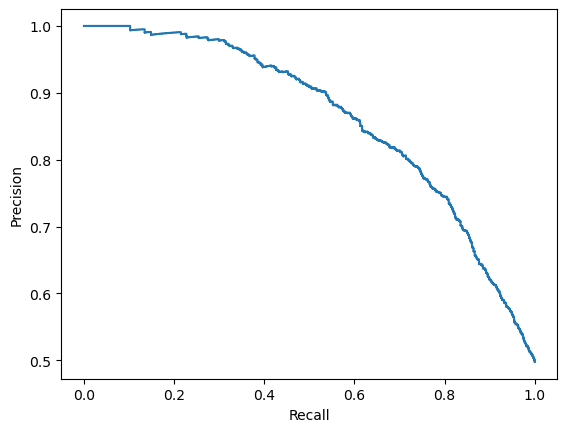

In [2]:
test_model(model_name="all-distilroberta-v1")

No sentence-transformers model found with name /home/bardanik-rem/.cache/torch/sentence_transformers/bert-base-uncased. Creating a new one with MEAN pooling.


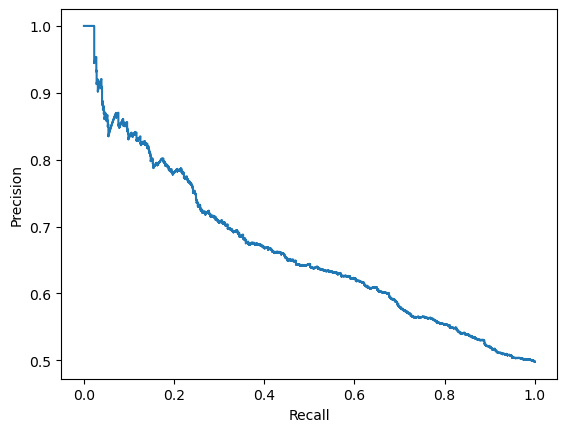

In [3]:
test_model(model_name="bert-base-uncased")

In [18]:
from transformers import AutoTokenizer, BertModel
import torch
model = BertModel.from_pretrained("bert-base-uncased")

test_model(input_model=model)

AttributeError: 'BertModel' object has no attribute 'encode'